# ResNet Transfer Learning

Loading the pre-trained comvolutional models, removing the last layer and train with small data set.

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Reshape, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
%matplotlib inline
import glob

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from Transfer_learning_utils import convert_to_one_hot, loading_dataset, evaluate_model

Using TensorFlow backend.


In [2]:
from keras.applications import ResNet50
ResNetModel = ResNet50()
ResNetModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

Residuel Network is a moderate-sizied convolutional neural network. It has 50 layers and 25M parameters. This is less than 20% the size of VGG16/VGG19

## load training and testing data

In [4]:
selected_classes = ['beaver','pyramid','llama','lotus','crab','car_side']
folderpath = './../../../../../projects/computerVision/imageRecognition/Caltech101_Dataset/101_ObjectCategories/'

In [5]:
X_train, Y_train, X_test, Y_test = loading_dataset(folderpath = folderpath, classes = selected_classes)

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train, len(selected_classes)).T
Y_test = convert_to_one_hot(Y_test, len(selected_classes)).T

In [6]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 355
number of test examples = 88
X_train shape: (355, 224, 224, 3)
Y_train shape: (355, 6)
X_test shape: (88, 224, 224, 3)
Y_test shape: (88, 6)


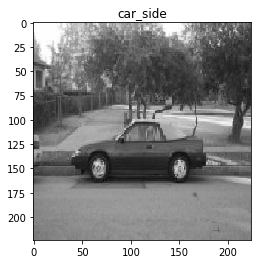

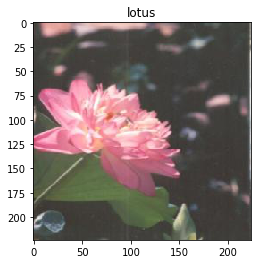

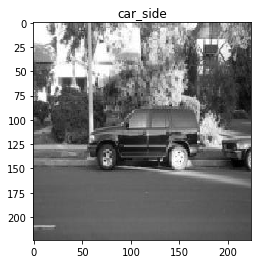

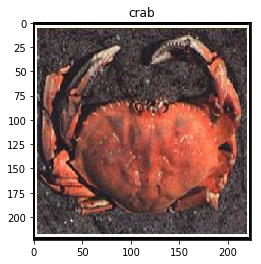

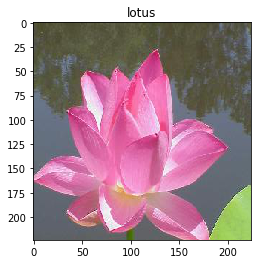

In [7]:
for i in range(5):
    plt.figure()
    plt.imshow(X_train[i]/255.)
    plt.title(selected_classes[np.argmax(Y_train[i])])

## Add new fianl dense layer, set ResNet layers non-trainable

In [8]:
for layer in ResNetModel.layers:
    layer.trainable = False

### Note for Res Net
The last 2 layers of ResNet are flatten and dense. We need to 
1. Remove the last dense
3. Attach a new reshape layer for classfication on new dataset with softmax activation 

In [9]:
new_dense = Dense(len(selected_classes), activation='softmax', name='new_final_layer', kernel_initializer = glorot_uniform(seed=0))(ResNetModel.layers[-2].output)

In [10]:
myResNet = Model(input = ResNetModel.input, output = new_dense)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ne...)`
  """Entry point for launching an IPython kernel.


In [11]:
myResNet.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [12]:
myResNet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [13]:
featureModel = Model(input = myResNet.input, output = myResNet.layers[-2].output)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  """Entry point for launching an IPython kernel.


In [14]:
nTrain = X_train.shape[0]
nTest = X_test.shape[0]

#nFeature = int(featureModel.output.shape[1])
nFeature = 2048

X_train_feature = np.zeros((nTrain, nFeature))
X_test_feature  = np.zeros((nTest, nFeature))

In [15]:
batch_size = 10
for i in range(0,nTrain,batch_size):
    iEnd = min([nTrain, i+batch_size])
    print('computing features for training data %d - %d' % (i, iEnd-1))
    X_train_feature[i:iEnd] = featureModel.predict(X_train[i:iEnd])    

computing features for training data 0 - 9
computing features for training data 10 - 19
computing features for training data 20 - 29
computing features for training data 30 - 39
computing features for training data 40 - 49
computing features for training data 50 - 59
computing features for training data 60 - 69
computing features for training data 70 - 79
computing features for training data 80 - 89
computing features for training data 90 - 99
computing features for training data 100 - 109
computing features for training data 110 - 119
computing features for training data 120 - 129
computing features for training data 130 - 139
computing features for training data 140 - 149
computing features for training data 150 - 159
computing features for training data 160 - 169
computing features for training data 170 - 179
computing features for training data 180 - 189
computing features for training data 190 - 199
computing features for training data 200 - 209
computing features for training dat

In [16]:
for i in range(0,nTest,batch_size):
    iEnd = min([nTest, i+batch_size])
    print('computing features for test data %d - %d' % (i, iEnd-1))
    X_test_feature[i:iEnd] = featureModel.predict(X_test[i:iEnd])   

computing features for test data 0 - 9
computing features for test data 10 - 19
computing features for test data 20 - 29
computing features for test data 30 - 39
computing features for test data 40 - 49
computing features for test data 50 - 59
computing features for test data 60 - 69
computing features for test data 70 - 79
computing features for test data 80 - 87


In [17]:
pca = decomposition.PCA(n_components = 2)

In [18]:
x_std = StandardScaler().fit_transform(X_train_feature)
x_feature_pca = pca.fit_transform(x_std)

In [19]:
Y_train_label = np.argmax(Y_train,axis=1)

Text(0.5,1,'feature space')

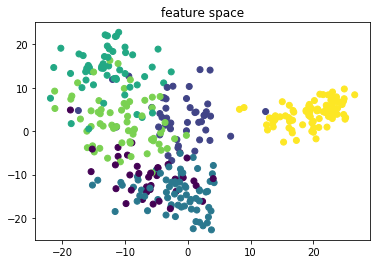

In [20]:
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=Y_train_label)
plt.title('feature space')

### Note:
Before we do anything, the first (n-1) layers of ResNet is already able to distinguage different classes. Here we compute the feature vectors of each training and testing data set, and plot the feature vectors (the first two dimensions in the pca space) colored by their labels. Note that the clusters are decent separated already. The separation is better than MobileNet, and slightly worse than VGG16

In [21]:
final_layer_input = Input(shape=(nFeature,))
final_layer_dense = Dense(len(selected_classes), activation='softmax', kernel_initializer = glorot_uniform(seed=0))(final_layer_input)
myResNet_patch = Model(inputs = final_layer_input, outputs = final_layer_dense)
myResNet_patch.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [22]:
myResNet_patch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 12,294
Trainable params: 12,294
Non-trainable params: 0
_________________________________________________________________


In [24]:
myResNet_patch.fit(X_train_feature, Y_train, epochs = 15, batch_size = 64)

Epoch 1/15
355/355 [==============================] - 0s 70us/step - loss: 0.0355 - acc: 1.0000
Epoch 2/15
355/355 [==============================] - 0s 53us/step - loss: 0.0312 - acc: 1.0000
Epoch 3/15
355/355 [==============================] - 0s 50us/step - loss: 0.0284 - acc: 1.0000
Epoch 4/15
355/355 [==============================] - 0s 45us/step - loss: 0.0258 - acc: 1.0000
Epoch 5/15
355/355 [==============================] - 0s 51us/step - loss: 0.0238 - acc: 1.0000
Epoch 6/15
355/355 [==============================] - 0s 53us/step - loss: 0.0218 - acc: 1.0000
Epoch 7/15
355/355 [==============================] - 0s 51us/step - loss: 0.0203 - acc: 1.0000
Epoch 8/15
355/355 [==============================] - 0s 56us/step - loss: 0.0189 - acc: 1.0000
Epoch 9/15
355/355 [==============================] - 0s 52us/step - loss: 0.0177 - acc: 1.0000
Epoch 10/15
355/355 [==============================] - 0s 55us/step - loss: 0.0167 - acc: 1.0000
Epoch 11/15
355/355 [==================

In [25]:
#the following code will take long time because we are computing the feature vector for each training data repeatedly

#myVGGNet.fit(X_train, Y_train, epochs = 2, batch_size = 32)

In [26]:
#evaluate_model(myVGGNet, X_train, Y_train, X_test, Y_test, maxItem = 20)

In [27]:
#prediction_result = myVGGNet.predict(X_test[0:10])
#predicted_labels = np.argmax(prediction_result,axis=1)

In [28]:
evaluate_model(myResNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)

Performance on Training data set (355)
355/355 [==============================] - 0s 446us/step
Loss = 0.0121796126149
Train Accuracy = 1.0
Performance on Testing data set (88)
88/88 [==============================] - 0s 63us/step
Loss = 0.120124058967
Test Accuracy = 0.954545449127


In [31]:
prediction_result = myResNet_patch.predict(X_test_feature)
predicted_labels = np.argmax(prediction_result,axis=1)
prediction_conf = np.max(prediction_result, axis = 1)

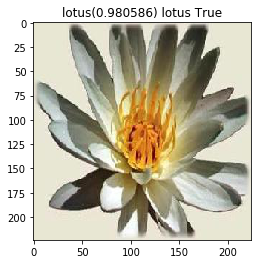

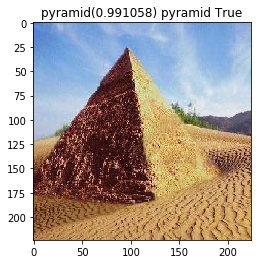

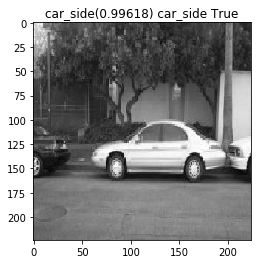

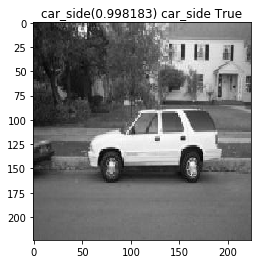

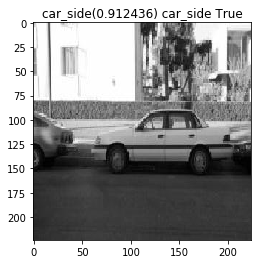

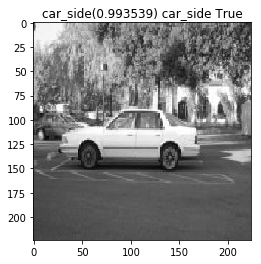

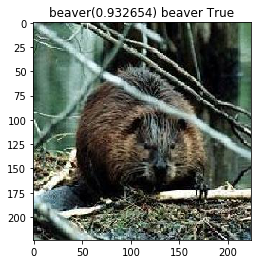

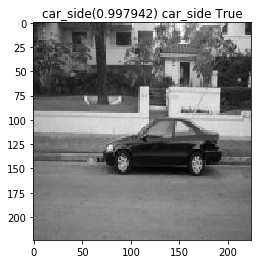

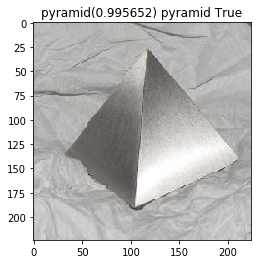

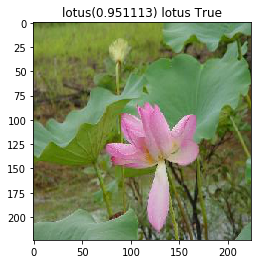

In [32]:
for i in range(10):
    actu = np.argmax(Y_test[i])
    plt.figure()
    plt.imshow(X_test[i]/255.)
    plt.title(selected_classes[predicted_labels[i]] + '(' + str(prediction_conf[i])+') ' + selected_classes[actu] + ' ' + str(predicted_labels[i]==actu))

## Note
The performance of transfer learning with ResNet achieved 100% accuracy with training dataset and 95.5% accuracy with test dataset. This is exactly the same with MobileNet. Training takes about the same time but computing feature vectors takes slightly longer time. The model is also 600% the size of MobileNet, and is 19% the size of VGG16.

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))